# The battle of Neighboorhoods

### Applied Data Science Capstone

Find the best place to open a Chinese restaurant in NYC

Author | Paola De Ros

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests

from geopy.geocoders import Nominatim

import os

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported')

Libraries imported


In [2]:
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python-3.8-main

  added / updated specs:
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.1.0               |             py_1         614 KB  conda-forge
    branca-0.4.2               |     pyhd8ed1ab_0          26 KB  conda-forge
    certifi-2021.5.30          |   py38h578d9bd_0         141 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    python_abi-3.8             |           2_cp38           4 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    widgetsnbextension-3.5.1   |   py38h578d9bd_4         1.8 MB  conda-forge
    ------------------------------------------------------------
          

In [3]:
CLIENT_ID = '2LGFZHBSRGVPUIAZ54XLHCXAKDVJEY1KFK5XKIVTYP1VWRRH' 
CLIENT_SECRET = 'ZW2EYTDDLJZACFJMENWF12RQK4KVGKU5TLNPH5F3ZMFTTPPS' 
VERSION = '20180605'

In [4]:
def geo_location(address):
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    radius=400
    LIMIT=100
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

In [5]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data.shape

(306, 4)

The total number of neighboorhoods in NYC is 306

## Data Analysis

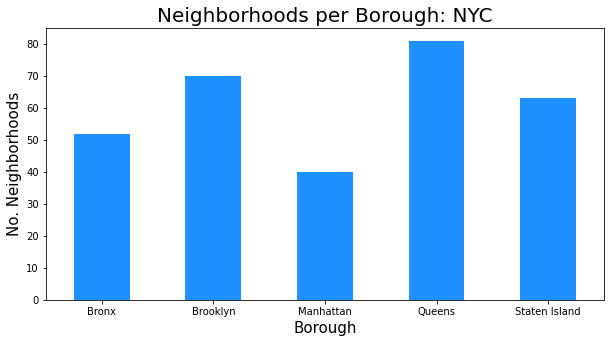

In [7]:
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color="dodgerblue" ) 
plt.title('Neighborhoods per Borough: NYC', fontsize = 20) 
plt.xlabel('Borough', fontsize = 15) 
plt.ylabel('No. Neighborhoods',fontsize = 15) 
plt.xticks(rotation = 'horizontal')
plt.show()

The borough that has more neighboorhoods is Queens

In [8]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
chinese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    chinese_restaurants=venues[venues['Category']=='Chinese Restaurant']   
    print('(',count,'/',len(ny_data),')','Chinese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(chinese_restaurants)))
    print(row)
    for resturant_detail in chinese_restaurants.values.tolist():
        id, name , category=resturant_detail
        chinese_rest_ny = chinese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Chinese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Chinese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Chinese Restaurants in Eastchester, Bronx:1
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Chinese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Chinese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Chinese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Chinese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Chinese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Chinese Restaurants in Norwood, Bronx:1
['

( 68 / 306 ) Chinese Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Chinese Restaurants in Gowanus, Brooklyn:1
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Chinese Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Chinese Restaurants in Park Slope, Brooklyn:1
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Chinese Restaurants in Cypress Hills, Brooklyn:1
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Chinese Restaurants in East New York, Brooklyn:2
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Chinese Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758905230874, -73.87936970045875]
( 75 / 306 ) Chinese Restaurants in Canarsie, Brooklyn:0
['Brooklyn', 'Canarsie', 40.63556432797428, -73.90209269

( 131 / 306 ) Chinese Restaurants in Woodside, Queens:1
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Chinese Restaurants in Jackson Heights, Queens:0
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Chinese Restaurants in Elmhurst, Queens:2
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Chinese Restaurants in Howard Beach, Queens:2
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Chinese Restaurants in Corona, Queens:1
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Chinese Restaurants in Forest Hills, Queens:1
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Chinese Restaurants in Kew Gardens, Queens:2
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Chinese Restaurants in Richmond Hill, Queens:0
['Queens', 'Richmond Hill', 40.69794731471763, -73.83183321446887]
( 139 / 306 ) C

( 198 / 306 ) Chinese Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Chinese Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Chinese Restaurants in Stapleton, Staten Island:1
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Chinese Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Chinese Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Chinese Restaurants in Grymes Hill, Staten Island:0
['Staten Island', 'Grymes Hill', 40.624184791313006, -74.08724819983729]
( 204 / 306 ) Chinese Restaurants in Todt Hill, Staten Island:0
['Staten Island', 'Todt Hill', 40.59706851814673, -74.1113288180088]
( 205 / 306 ) Chinese Restaurants in South Bea

( 259 / 306 ) Chinese Restaurants in Elm Park, Staten Island:1
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Chinese Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Chinese Restaurants in New Lots, Brooklyn:2
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Chinese Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Chinese Restaurants in Mill Basin, Brooklyn:2
['Brooklyn', 'Mill Basin', 40.61597423962336, -73.91515391550404]
( 264 / 306 ) Chinese Restaurants in Jamaica Hills, Queens:1
['Queens', 'Jamaica Hills', 40.71145964370482, -73.79646462081593]
( 265 / 306 ) Chinese Restaurants in Utopia, Queens:0
['Queens', 'Utopia', 40.73350025429757, -73.79671678028349]
( 266 / 306 ) Chinese Restaurants in Pomonok, Queens:0
['Queens', 'Pomonok', 40.73493618075478, -73.80486120

In [9]:
chinese_rest_ny.to_csv('chinese_rest_ny_tocsv1.csv')

In [10]:
chinese_ny = pd.read_csv('chinese_rest_ny_tocsv1.csv')
chinese_rest_ny.tail()

,Borough,Neighborhood,ID,Name
178,Bronx,Allerton,4c7dbf7f10916dcba78e2a96,Chef King
179,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant
180,Bronx,Kingsbridge Heights,4c7851e03badb1f7137c4b54,Yu Hua Restaurant
181,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food
182,Staten Island,Fox Hills,4ef6a4fb469012b8c0695703,China Garden


In [11]:
chinese_rest_ny.shape

(183, 4)

Result: there are 183 Chinese restaurants in NYC

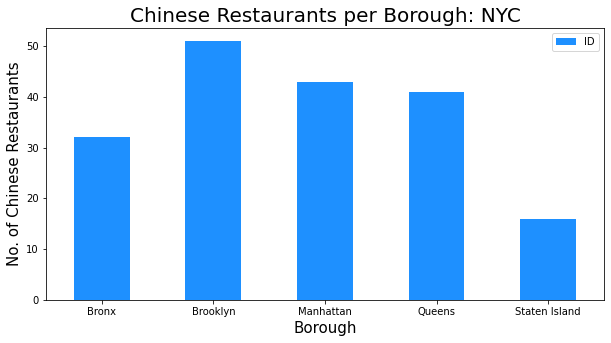

In [12]:
chinese_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color='dodgerblue')
plt.title('Chinese Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

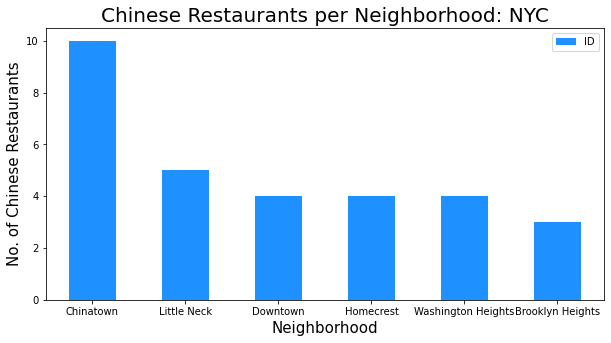

In [13]:
NOofNeigh = 6
chinese_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color='dodgerblue')
plt.title('Chinese Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Chinese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [14]:
chinese_rest_ny[chinese_rest_ny['Neighborhood']=='Chinatown']

,Borough,Neighborhood,ID,Name
63,Manhattan,Chinatown,4db3374590a0843f295fb69b,Spicy Village
64,Manhattan,Chinatown,4a96bf8ff964a520ce2620e3,Wah Fung Number 1 Fast Food 華豐快餐店
65,Manhattan,Chinatown,5894c9a15e56b417cf79e553,Xi'an Famous Foods
66,Manhattan,Chinatown,3fd66200f964a520b1ea1ee3,Great N.Y. Noodletown
67,Manhattan,Chinatown,59d828f0916bc1155fde2c04,Hwa Yuan
68,Manhattan,Chinatown,5c965dad5455b2002c058659,Yi Ji Shi Mo Noodle Corp
69,Manhattan,Chinatown,4afff2b4f964a520583a22e3,Sun Hing Lung Ho Fun Tofu
70,Manhattan,Chinatown,4bc34a294cdfc9b6a01a9721,Happy Cafe (Happy Express Cafe)
71,Manhattan,Chinatown,3fd66200f964a520ceea1ee3,Deluxe Green Bo Restaurant
72,Manhattan,Chinatown,3fd66200f964a520ede41ee3,Big Wong King 大旺


Result: Chinatown in Manhattan has the highest number of Chinese Restaurants with a total count of 10

### Ranking Analysis

In [15]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
chinese_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in chinese_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
       
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(chinese_rest_ny),')','processed')
    chinese_rest_stats_ny = chinese_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
chinese_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '614c84cb71c6475ac989c8b0'}, 'response': {'venue': {'id': '4dabc3dc93a04642f09ccabd', 'name': 'Xing Lung Chinese Restaurant', 'contact': {'phone': '7183241014', 'formattedPhone': '(718) 324-1014'}, 'location': {'address': '3828 B Dyre Ave', 'crossStreet': 'E 233 St', 'lat': 40.8887854684858, 'lng': -73.83122576835156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8887854684858, 'lng': -73.83122576835156}], 'postalCode': '10466', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3828 B Dyre Ave (E 233 St)', 'Bronx, NY 10466', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xing-lung-chinese-restaurant/4dabc3dc93a04642f09ccabd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': Fals

{'meta': {'code': 200, 'requestId': '614c84cbf5081b31bc3a3345'}, 'response': {'venue': {'id': '4bc8f646b6c49c74d8898d91', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '7188282225', 'formattedPhone': '(718) 828-2225'}, 'location': {'address': '2049 Williamsbridge Rd', 'lat': 40.855168, 'lng': -73.855587, 'labeledLatLngs': [{'label': 'display', 'lat': 40.855168, 'lng': -73.855587}], 'postalCode': '10461', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2049 Williamsbridge Rd', 'Bronx, NY 10461', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4bc8f646b6c49c74d8898d91', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'url': 'http://www.grea

{'meta': {'code': 200, 'requestId': '614c84cc9aa54e098db57ed8'}, 'response': {'venue': {'id': '4d081644e554721e5423c0f8', 'name': 'Wai Kang Kitchen Chinese Food', 'contact': {'phone': '7189332797', 'formattedPhone': '(718) 933-2797'}, 'location': {'address': '39 Bedford Park Blvd W', 'crossStreet': 'Grand concourse', 'lat': 40.8726151696897, 'lng': -73.88842540381232, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8726151696897, 'lng': -73.88842540381232}], 'postalCode': '10468', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39 Bedford Park Blvd W (Grand concourse)', 'Bronx, NY 10468', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wai-kang-kitchen-chinese-food/4d081644e554721e5423c0f8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '614c84cd6b88e3541ec1ff51'}, 'response': {'venue': {'id': '4cd88b521891236a79d8360b', 'name': 'Hong Kong', 'contact': {'phone': '7187920219', 'formattedPhone': '(718) 792-0219'}, 'location': {'address': '459 Morris Park Ave', 'lat': 40.8408088684082, 'lng': -73.87335205078125, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.840752, 'lng': -73.873093}, {'label': 'display', 'lat': 40.8408088684082, 'lng': -73.87335205078125}], 'postalCode': '10460', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['459 Morris Park Ave', 'Bronx, NY 10460', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hong-kong/4cd88b521891236a79d8360b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

( 12 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84cdb7b31a07c519fce5'}, 'response': {'venue': {'id': '4df3e68688772e1f81559d14', 'name': 'Good Choice Chinese Restaurant', 'contact': {'phone': '7185858866', 'formattedPhone': '(718) 585-8866'}, 'location': {'address': '570 E 138th St', 'crossStreet': 'at St. Anns Ave.', 'lat': 40.806515999999995, 'lng': -73.917477, 'labeledLatLngs': [{'label': 'display', 'lat': 40.806515999999995, 'lng': -73.917477}, {'label': 'entrance', 'lat': 40.806629, 'lng': -73.917397}], 'postalCode': '10454', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['570 E 138th St (at St. Anns Ave.)', 'Bronx, NY 10454', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-choice-chinese-restaurant/4df3e68688772e1f81559d14', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.n

{'meta': {'code': 200, 'requestId': '614c84ce13e861268467d8d2'}, 'response': {'venue': {'id': '4cc63e36bde8f04dcbfeb54b', 'name': 'Golden City Chinese Restaurant', 'contact': {}, 'location': {'address': '805 Soundview Ave', 'lat': 40.82143531101194, 'lng': -73.86637130850734, 'labeledLatLngs': [{'label': 'display', 'lat': 40.82143531101194, 'lng': -73.86637130850734}], 'postalCode': '10473', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['805 Soundview Ave', 'Bronx, NY 10473', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-city-chinese-restaurant/4cc63e36bde8f04dcbfeb54b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'

( 18 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84cea79fae22eda77046'}, 'response': {'venue': {'id': '4d7273065f0037048835e0a0', 'name': 'King Wok', 'contact': {'phone': '7189311900', 'formattedPhone': '(718) 931-1900'}, 'location': {'address': '2096 Starling Ave', 'crossStreet': 'Olmstead', 'lat': 40.835815000000004, 'lng': -73.855319, 'labeledLatLngs': [{'label': 'display', 'lat': 40.835815000000004, 'lng': -73.855319}, {'label': 'entrance', 'lat': 40.835899, 'lng': -73.855334}], 'postalCode': '10462', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2096 Starling Ave (Olmstead)', 'Bronx, NY 10462', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/king-wok/4d7273065f0037048835e0a0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 

{'meta': {'code': 200, 'requestId': '614c84cf293a2f02852e8c90'}, 'response': {'venue': {'id': '4ca4fda4d971b1f77da5f2e0', 'name': 'Golden Phoenix Chinese Restaurant', 'contact': {'phone': '7185488888', 'formattedPhone': '(718) 548-8888'}, 'location': {'address': '5646 Riverdale Ave', 'crossStreet': 'West 258th Street', 'lat': 40.90568876262962, 'lng': -73.90429772559949, 'labeledLatLngs': [{'label': 'display', 'lat': 40.90568876262962, 'lng': -73.90429772559949}, {'label': 'entrance', 'lat': 40.905658, 'lng': -73.90424}], 'postalCode': '10471', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5646 Riverdale Ave (West 258th Street)', 'Bronx, NY 10471', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-phoenix-chinese-restaurant/4ca4fda4d971b1f77da5f2e0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.

{'meta': {'code': 200, 'requestId': '614c84cf648dc553b2c0ffe7'}, 'response': {'venue': {'id': '4eadecbf9911d5c95181ee84', 'name': 'Yummy House', 'contact': {'phone': '9177836777', 'formattedPhone': '(917) 783-6777'}, 'location': {'address': '2452 Eastchester Rd', 'crossStreet': 'Mace Ave.', 'lat': 40.86249, 'lng': -73.843079, 'labeledLatLngs': [{'label': 'display', 'lat': 40.86249, 'lng': -73.843079}, {'label': 'entrance', 'lat': 40.862476, 'lng': -73.843227}], 'postalCode': '10469', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2452 Eastchester Rd (Mace Ave.)', 'Bronx, NY 10469', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yummy-house/4eadecbf9911d5c95181ee84', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': 

( 25 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84d071c6475ac989d51c'}, 'response': {'venue': {'id': '5553702c498ecb85f99d8f37', 'name': 'XIN', 'contact': {'phone': '3476626222', 'formattedPhone': '(347) 662-6222', 'twitter': 'xinbayridge'}, 'location': {'address': '8320 3rd Ave', 'lat': 40.62508203621133, 'lng': -74.0304936920825, 'labeledLatLngs': [{'label': 'display', 'lat': 40.62508203621133, 'lng': -74.0304936920825}, {'label': 'entrance', 'lat': 40.625159, 'lng': -74.030522}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8320 3rd Ave', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xin/5553702c498ecb85f99d8f37', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tru

{'meta': {'code': 200, 'requestId': '614c84d0a50cac20f89c6e90'}, 'response': {'venue': {'id': '4c2169947e85c928b88aba21', 'name': 'Panda Chinese Restaurant', 'contact': {'phone': '7182592831', 'formattedPhone': '(718) 259-2831', 'twitter': 'pandaexpress'}, 'location': {'address': '7323 20th Ave', 'lat': 40.611388, 'lng': -73.99078399999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.611388, 'lng': -73.99078399999999}], 'postalCode': '11204', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['7323 20th Ave', 'Brooklyn, NY 11204', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-chinese-restaurant/4c2169947e85c928b88aba21', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'p

{'meta': {'code': 200, 'requestId': '614c84d155b5a316e29fc5cf'}, 'response': {'venue': {'id': '4fab21d1e4b0be1a3d54b15c', 'name': 'king', 'contact': {'phone': '7186299669', 'formattedPhone': '(718) 629-9669'}, 'location': {'address': '4204 Avenue D', 'lat': 40.64143371582031, 'lng': -73.93680572509766, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64143371582031, 'lng': -73.93680572509766}], 'postalCode': '11203', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4204 Avenue D', 'Brooklyn, NY 11203', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/king/4fab21d1e4b0be1a3d54b15c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': 

{'meta': {'code': 200, 'requestId': '614c84d2e08d6b510c262c6d'}, 'response': {'venue': {'id': '54e39b14498e9c646b42958e', 'name': 'East Wind Snack Shop', 'contact': {'phone': '9292950188', 'formattedPhone': '(929) 295-0188'}, 'location': {'address': '471 16th St', 'crossStreet': 'at Prospect Park West', 'lat': 40.660297, 'lng': -73.980169, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660297, 'lng': -73.980169}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['471 16th St (at Prospect Park West)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-wind-snack-shop/54e39b14498e9c646b42958e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '614c84d2ee07201e9973e5ef'}, 'response': {'venue': {'id': '4c06e2470e0a2d7fdf8aec0c', 'name': '#1 Garden Chinese Food', 'contact': {'phone': '7188321795', 'formattedPhone': '(718) 832-1795'}, 'location': {'address': '221 Prospect Park W', 'lat': 40.660248811093595, 'lng': -73.98054235147856, 'labeledLatLngs': [{'label': 'display', 'lat': 40.660248811093595, 'lng': -73.98054235147856}, {'label': 'entrance', 'lat': 40.660106, 'lng': -73.980445}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221 Prospect Park W', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/1-garden-chinese-food/4c06e2470e0a2d7fdf8aec0c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary

( 36 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84d3a50cac20f89c76ae'}, 'response': {'venue': {'id': '4a986a9cf964a520e82b20e3', 'name': 'Great Wall Chinese Food', 'contact': {'phone': '7188552630', 'formattedPhone': '(718) 855-2630'}, 'location': {'address': '60 Henry St', 'crossStreet': 'btw Cranberry St and Orange St', 'lat': 40.698983696296274, 'lng': -73.99218529980111, 'labeledLatLngs': [{'label': 'display', 'lat': 40.698983696296274, 'lng': -73.99218529980111}], 'postalCode': '11201', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60 Henry St (btw Cranberry St and Orange St)', 'Brooklyn, NY 11201', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-food/4a986a9cf964a520e82b20e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asia

{'meta': {'code': 200, 'requestId': '614c84d41ea9d165bc4b19dc'}, 'response': {'venue': {'id': '4b09dc38f964a520cf1e23e3', 'name': 'Ting Hua', 'contact': {'phone': '7188526287', 'formattedPhone': '(718) 852-6287'}, 'location': {'address': '351 Smith St', 'crossStreet': 'at Carroll St.', 'lat': 40.6799366374633, 'lng': -73.99512985321104, 'labeledLatLngs': [{'label': 'display', 'lat': 40.6799366374633, 'lng': -73.99512985321104}, {'label': 'entrance', 'lat': 40.679872, 'lng': -73.994989}], 'postalCode': '11231', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['351 Smith St (at Carroll St.)', 'Brooklyn, NY 11231', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ting-hua/4b09dc38f964a520cf1e23e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'pr

{'meta': {'code': 200, 'requestId': '614c84d4a5552d7a56780d4e'}, 'response': {'venue': {'id': '49bb541ff964a520e3531fe3', 'name': 'Hunan Delight', 'contact': {'phone': '7187891400', 'formattedPhone': '(718) 789-1400'}, 'location': {'address': '752 Union St', 'crossStreet': 'b/t 5th and 6th ave', 'lat': 40.67546106658002, 'lng': -73.97804145177376, 'labeledLatLngs': [{'label': 'display', 'lat': 40.67546106658002, 'lng': -73.97804145177376}, {'label': 'entrance', 'lat': 40.675398, 'lng': -73.978171}], 'postalCode': '11215', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['752 Union St (b/t 5th and 6th ave)', 'Brooklyn, NY 11215', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hunan-delight/49bb541ff964a520e3531fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 

{'meta': {'code': 200, 'requestId': '614c84d4504eac379e551355'}, 'response': {'venue': {'id': '4f326c1a19836c91c7d64648', 'name': 'Wo Hop Chinese Restaurant', 'contact': {'phone': '7182357955', 'formattedPhone': '(718) 235-7955'}, 'location': {'address': '3150 Fulton St', 'lat': 40.681668, 'lng': -73.878741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.681668, 'lng': -73.878741}, {'label': 'entrance', 'lat': 40.681716, 'lng': -73.878621}], 'postalCode': '11208', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3150 Fulton St', 'Brooklyn, NY 11208', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wo-hop-chinese-restaurant/4f326c1a19836c91c7d64648', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '614c84d594006d1f5b3ed33c'}, 'response': {'venue': {'id': '4d4a03494509721eab1d2ab0', 'name': 'Welcome Seafood Restaurant', 'contact': {'phone': '7182655048', 'formattedPhone': '(718) 265-5048'}, 'location': {'address': '2050 86th St', 'crossStreet': 'Bay 25th & 26th St.', 'lat': 40.60239878030012, 'lng': -73.99904604649204, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60239878030012, 'lng': -73.99904604649204}], 'postalCode': '11214', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2050 86th St (Bay 25th & 26th St.)', 'Brooklyn, NY 11214', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/welcome-seafood-restaurant/4d4a03494509721eab1d2ab0', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True

{'meta': {'code': 200, 'requestId': '614c84d5c8479a7bef9ff560'}, 'response': {'venue': {'id': '4a71ff01f964a52016da1fe3', 'name': 'Kum Kau', 'contact': {'phone': '7186381850', 'formattedPhone': '(718) 638-1850'}, 'location': {'address': '463 Myrtle Ave', 'crossStreet': 'btwn Washington Ave & Hall St', 'lat': 40.693373086368084, 'lng': -73.96675330374048, 'labeledLatLngs': [{'label': 'display', 'lat': 40.693373086368084, 'lng': -73.96675330374048}, {'label': 'entrance', 'lat': 40.693463, 'lng': -73.966722}], 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['463 Myrtle Ave (btwn Washington Ave & Hall St)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kum-kau/4a71ff01f964a52016da1fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/

{'meta': {'code': 200, 'requestId': '614c84d68bfb3141570611d2'}, 'response': {'venue': {'id': '4e878888754adf6585da4a5d', 'name': 'Hardee', 'contact': {'phone': '7188752148', 'formattedPhone': '(718) 875-2148'}, 'location': {'address': '351 Myrtle Ave', 'crossStreet': 'btwn Carlton Ave. & Adelphi St.', 'lat': 40.693329386717686, 'lng': -73.9722990989685, 'postalCode': '11205', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['351 Myrtle Ave (btwn Carlton Ave. & Adelphi St.)', 'Brooklyn, NY 11205', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hardee/4e878888754adf6585da4a5d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d16e941735', 'name': 'Fast Food Restaurant', 'pluralName': 'Fast Food Restaurants'

{'meta': {'code': 200, 'requestId': '614c84d608818850aa28866c'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

{'meta': {'code': 200, 'requestId': '614c84d7a5552d7a56781412'}, 'response': {'venue': {'id': '585d72449f25836f2b2b7a1b', 'name': 'Xifu Food', 'contact': {'phone': '7182378886', 'formattedPhone': '(718) 237-8886'}, 'location': {'address': '318 Livingston St', 'lat': 40.688027, 'lng': -73.982088, 'labeledLatLngs': [{'label': 'display', 'lat': 40.688027, 'lng': -73.982088}, {'label': 'entrance', 'lat': 40.688057, 'lng': -73.982014}], 'postalCode': '11217', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['318 Livingston St', 'Brooklyn, NY 11217', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xifu-food/585d72449f25836f2b2b7a1b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Dumpling 

No data available for id= 4de82215d4c0faa56427f97e
( 55 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84d7b733027375da683f'}, 'response': {'venue': {'id': '4f4464ed19836ed00193d4a6', 'name': 'Good Taste Chinese Restaurant', 'contact': {'phone': '7184856868', 'formattedPhone': '(718) 485-6868'}, 'location': {'address': '126 Hull St', 'lat': 40.679237, 'lng': -73.910843, 'labeledLatLngs': [{'label': 'display', 'lat': 40.679237, 'lng': -73.910843}, {'label': 'entrance', 'lat': 40.679221, 'lng': -73.9109}], 'postalCode': '11233', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['126 Hull St', 'Brooklyn, NY 11233', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/good-taste-chinese-restaurant/4f4464ed19836ed00193d4a6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

{'meta': {'code': 200, 'requestId': '614c84d83810c5424fad7f9a'}, 'response': {'venue': {'id': '3fd66200f964a5206bf11ee3', 'name': 'M Shanghai Bistro', 'contact': {'phone': '7183849300', 'formattedPhone': '(718) 384-9300', 'twitter': 'm_shanghai'}, 'location': {'address': '292 Grand St', 'crossStreet': 'btwn Roebling St & Havemeyer St', 'lat': 40.71302151768249, 'lng': -73.95752069380897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71302151768249, 'lng': -73.95752069380897}, {'label': 'entrance', 'lat': 40.712937, 'lng': -73.957563}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['292 Grand St (btwn Roebling St & Havemeyer St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m-shanghai-bistro/3fd66200f964a5206bf11ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '614c84d8298f5e1b75106891'}, 'response': {'venue': {'id': '3fd66200f964a5206bf11ee3', 'name': 'M Shanghai Bistro', 'contact': {'phone': '7183849300', 'formattedPhone': '(718) 384-9300', 'twitter': 'm_shanghai'}, 'location': {'address': '292 Grand St', 'crossStreet': 'btwn Roebling St & Havemeyer St', 'lat': 40.71302151768249, 'lng': -73.95752069380897, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71302151768249, 'lng': -73.95752069380897}, {'label': 'entrance', 'lat': 40.712937, 'lng': -73.957563}], 'postalCode': '11211', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['292 Grand St (btwn Roebling St & Havemeyer St)', 'Brooklyn, NY 11211', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m-shanghai-bistro/3fd66200f964a5206bf11ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix

{'meta': {'code': 200, 'requestId': '614c84d81d9c4336e50b5aa0'}, 'response': {'venue': {'id': '4b512cbaf964a520f64527e3', 'name': 'ha ha chinese', 'contact': {'phone': '7188338078', 'formattedPhone': '(718) 833-8078'}, 'location': {'address': '9212 4th Ave', 'crossStreet': '92nd + 93rd and 4th ave', 'lat': 40.618022230237116, 'lng': -74.03030968368607, 'labeledLatLngs': [{'label': 'display', 'lat': 40.618022230237116, 'lng': -74.03030968368607}, {'label': 'entrance', 'lat': 40.618092, 'lng': -74.030468}], 'postalCode': '11209', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['9212 4th Ave (92nd + 93rd and 4th ave)', 'Brooklyn, NY 11209', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ha-ha-chinese/4b512cbaf964a520f64527e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food

( 63 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84d9298f5e1b75106b2c'}, 'response': {'venue': {'id': '4db3374590a0843f295fb69b', 'name': 'Spicy Village', 'contact': {'phone': '2126258299', 'formattedPhone': '(212) 625-8299', 'twitter': 'spicyvillageny', 'facebook': '427178540674177', 'facebookName': 'Spicy Village'}, 'location': {'address': '68 Forsyth St Frnt B', 'crossStreet': 'btwn Grand & Hester St', 'lat': 40.71701, 'lng': -73.99353, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71701, 'lng': -73.99353}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['68 Forsyth St Frnt B (btwn Grand & Hester St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/spicy-village/4db3374590a0843f295fb69b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chines

{'meta': {'code': 200, 'requestId': '614c84d91241763d32449866'}, 'response': {'venue': {'id': '4a96bf8ff964a520ce2620e3', 'name': 'Wah Fung Number 1 Fast Food 華豐快餐店', 'contact': {'phone': '2129255175', 'formattedPhone': '(212) 925-5175'}, 'location': {'address': '79 Chrystie St', 'crossStreet': 'btwn Hester St & Grand St', 'lat': 40.71727831655619, 'lng': -73.99417731304892, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71727831655619, 'lng': -73.99417731304892}, {'label': 'entrance', 'lat': 40.717303, 'lng': -73.994439}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['79 Chrystie St (btwn Hester St & Grand St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wah-fung-number-1-fast-food-%E8%8F%AF%E8%B1%90%E5%BF%AB%E9%A4%90%E5%BA%97/4a96bf8ff964a520ce2620e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', '

{'meta': {'code': 200, 'requestId': '614c84d983341f01221c6f2f'}, 'response': {'venue': {'id': '5894c9a15e56b417cf79e553', 'name': "Xi'an Famous Foods", 'contact': {'twitter': 'xianfoods', 'facebook': '90354836008', 'facebookUsername': 'xianfoods', 'facebookName': "Xi'an Famous Foods 西安名吃"}, 'location': {'address': '45 Bayard St', 'crossStreet': 'Bowery', 'lat': 40.715231941715004, 'lng': -73.99726288220869, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715231941715004, 'lng': -73.99726288220869}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45 Bayard St (Bowery)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5894c9a15e56b417cf79e553', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

                         ID                   Name  Likes  Rating  Tips
0  3fd66200f964a520b1ea1ee3  Great N.Y. Noodletown    547     8.1   286
( 67 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84daecb6c7335400991d'}, 'response': {'venue': {'id': '59d828f0916bc1155fde2c04', 'name': 'Hwa Yuan', 'contact': {'phone': '2129666002', 'formattedPhone': '(212) 966-6002', 'instagram': 'hwa.yuan.nyc', 'facebook': '463197850727690', 'facebookUsername': 'HwaYuanNYC', 'facebookName': 'Hwa Yuan 華園'}, 'location': {'address': '42 E Broadway', 'lat': 40.713618266530226, 'lng': -73.99597818966741, 'labeledLatLngs': [{'label': 'display', 'lat': 40.713618266530226, 'lng': -73.99597818966741}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42 E Broadway', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hwa-yuan/59d828f0916bc1155fde2c04', 'categories': [{'id': '4bf58dd8d48988d145941735'

{'meta': {'code': 200, 'requestId': '614c84da6b646a172c306365'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {'phone': '6462336311', 'formattedPhone': '(646) 233-6311'}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '614c84da95238472a5121851'}, 'response': {'venue': {'id': '4afff2b4f964a520583a22e3', 'name': 'Sun Hing Lung Ho Fun Tofu', 'contact': {'phone': '2129627032', 'formattedPhone': '(212) 962-7032'}, 'location': {'address': '58 Henry St', 'crossStreet': 'Market', 'lat': 40.71296798032269, 'lng': -73.99514878725047, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71296798032269, 'lng': -73.99514878725047}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['58 Henry St (Market)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sun-hing-lung-ho-fun-tofu/4afff2b4f964a520583a22e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats'

{'meta': {'code': 200, 'requestId': '614c84db0d9b781a9812270d'}, 'response': {'venue': {'id': '3fd66200f964a520ceea1ee3', 'name': 'Deluxe Green Bo Restaurant', 'contact': {'phone': '2126252359', 'formattedPhone': '(212) 625-2359', 'twitter': 'deluxegreenbo'}, 'location': {'address': '66 Bayard St', 'crossStreet': 'btwn Elizabeth & Mott St', 'lat': 40.715544918133155, 'lng': -73.99813747002635, 'labeledLatLngs': [{'label': 'display', 'lat': 40.715544918133155, 'lng': -73.99813747002635}, {'label': 'entrance', 'lat': 40.715543, 'lng': -73.998033}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['66 Bayard St (btwn Elizabeth & Mott St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/deluxe-green-bo-restaurant/3fd66200f964a520ceea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon':

{'meta': {'code': 200, 'requestId': '614c84db5adca64d17263f60'}, 'response': {'venue': {'id': '4b292f38f964a520939a24e3', 'name': 'Yang Garden', 'contact': {'phone': '2127810055', 'formattedPhone': '(212) 781-0055', 'twitter': 'yang187garden'}, 'location': {'address': '816 W 187th St', 'crossStreet': 'Pinehurst', 'lat': 40.85530896752232, 'lng': -73.93783226069496, 'labeledLatLngs': [{'label': 'display', 'lat': 40.85530896752232, 'lng': -73.93783226069496}, {'label': 'entrance', 'lat': 40.855266, 'lng': -73.937644}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['816 W 187th St (Pinehurst)', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yang-garden/4b292f38f964a520939a24e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/a

{'meta': {'code': 200, 'requestId': '614c84db5adca64d1726408e'}, 'response': {'venue': {'id': '4b8d55aef964a52050f532e3', 'name': 'Golden Star', 'contact': {'phone': '2129285454', 'formattedPhone': '(212) 928-5454'}, 'location': {'address': '4247 Broadway', 'lat': 40.84972502907437, 'lng': -73.93625936786627, 'labeledLatLngs': [{'label': 'display', 'lat': 40.84972502907437, 'lng': -73.93625936786627}, {'label': 'entrance', 'lat': 40.849812, 'lng': -73.936319}], 'postalCode': '10033', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4247 Broadway', 'New York, NY 10033', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-star/4b8d55aef964a52050f532e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

                         ID                           Name  Likes  Rating  \
0  4aaed36bf964a520736320e3  Great Wall Chinese Restaurant      8     6.0   

   Tips  
0     9  
( 77 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84dcdc6d5c2d0a71cc9f'}, 'response': {'venue': {'id': '4bd5f4d229eb9c74c64594e1', 'name': '"U" Like', 'contact': {'phone': '2125693333', 'formattedPhone': '(212) 569-3333'}, 'location': {'address': '4926 Broadway', 'crossStreet': 'at W. 207th St', 'lat': 40.8675317158944, 'lng': -73.92156645636662, 'labeledLatLngs': [{'label': 'display', 'lat': 40.8675317158944, 'lng': -73.92156645636662}, {'label': 'entrance', 'lat': 40.867394, 'lng': -73.921621}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4926 Broadway (at W. 207th St)', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/u-like/4bd5f4d229eb9c74c64594e1', 'categories': [{'id': '4bf58dd8d48988d

                         ID      Name  Likes  Rating  Tips
0  4bd5f4d229eb9c74c64594e1  "U" Like     11     7.0     7
( 78 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84dc9aa54e098db5a88c'}, 'response': {'venue': {'id': '4b9aeeedf964a52086e435e3', 'name': 'Lotus Express', 'contact': {'phone': '2125698899', 'formattedPhone': '(212) 569-8899'}, 'location': {'address': '4840 Broadway', 'lat': 40.866279999999996, 'lng': -73.92456700000001, 'labeledLatLngs': [{'label': 'display', 'lat': 40.866279999999996, 'lng': -73.92456700000001}, {'label': 'entrance', 'lat': 40.866326, 'lng': -73.924612}], 'postalCode': '10034', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['4840 Broadway', 'New York, NY 10034', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lotus-express/4b9aeeedf964a52086e435e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName':

( 81 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84dd966a174f63f7c357'}, 'response': {'venue': {'id': '4bf348fce5eba593c8711e90', 'name': 'Crispy Bamboo Village', 'contact': {'phone': '2126945391', 'formattedPhone': '(212) 694-5391'}, 'location': {'address': '2526 Frederick Douglass Blvd', 'crossStreet': '135th St', 'lat': 40.81627823973171, 'lng': -73.94693839905996, 'labeledLatLngs': [{'label': 'display', 'lat': 40.81627823973171, 'lng': -73.94693839905996}, {'label': 'entrance', 'lat': 40.816152, 'lng': -73.946596}], 'postalCode': '10030', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2526 Frederick Douglass Blvd (135th St)', 'New York, NY 10030', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/crispy-bamboo-village/4bf348fce5eba593c8711e90', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'http

{'meta': {'code': 200, 'requestId': '614c84dd6a98015b7351a4bd'}, 'response': {'venue': {'id': '5465906e498e0cb221c063e1', 'name': 'Pig Heaven', 'contact': {'phone': '2127444333', 'formattedPhone': '(212) 744-4333', 'facebook': '1673948389361231', 'facebookUsername': 'pigheavennyc', 'facebookName': 'Pig Heaven'}, 'location': {'address': '1420 3rd Ave', 'crossStreet': '81st', 'lat': 40.7754503, 'lng': -73.95683919999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7754503, 'lng': -73.95683919999999}], 'postalCode': '10028', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1420 3rd Ave (81st)', 'New York, NY 10028', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pig-heaven/5465906e498e0cb221c063e1', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '614c84dddc6d5c2d0a71d06a'}, 'response': {'venue': {'id': '4ea5be4af5b9efc002cccdea', 'name': 'Shanghai', 'contact': {'phone': '2122888067', 'formattedPhone': '(212) 288-8067'}, 'location': {'address': '1388 2nd Ave', 'crossStreet': 'btwn 71st & 72nd St', 'lat': 40.768334, 'lng': -73.958493, 'labeledLatLngs': [{'label': 'display', 'lat': 40.768334, 'lng': -73.958493}, {'label': 'entrance', 'lat': 40.768342, 'lng': -73.958499}], 'postalCode': '10021', 'cc': 'US', 'neighborhood': 'Upper East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1388 2nd Ave (btwn 71st & 72nd St)', 'New York, NY 10021', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/shanghai/4ea5be4af5b9efc002cccdea', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix

{'meta': {'code': 200, 'requestId': '614c84de966a174f63f7c5b4'}, 'response': {'venue': {'id': '56759406498ecd2d68a85eec', 'name': 'Panda Express', 'contact': {}, 'location': {'lat': 40.76566581236336, 'lng': -73.95745129061507, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76566581236336, 'lng': -73.95745129061507}, {'label': 'entrance', 'lat': 40.76577, 'lng': -73.957687}], 'postalCode': '10065', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 10065', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/panda-express/56759406498ecd2d68a85eec', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 

{'meta': {'code': 200, 'requestId': '614c84dee08d6b510c2649cb'}, 'response': {'venue': {'id': '5529bfd8498ec6ce692d8015', 'name': 'Han Dynasty', 'contact': {'phone': '2128589060', 'formattedPhone': '(212) 858-9060'}, 'location': {'address': '215 W 85th St', 'crossStreet': 'at Broadway', 'lat': 40.78761996790675, 'lng': -73.97635945297974, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78761996790675, 'lng': -73.97635945297974}], 'postalCode': '10024', 'cc': 'US', 'neighborhood': 'Upper West Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['215 W 85th St (at Broadway)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/han-dynasty/5529bfd8498ec6ce692d8015', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'veri

{'meta': {'code': 200, 'requestId': '614c84de0d9b781a98122fdd'}, 'response': {'venue': {'id': '4aed1141f964a52001cd21e3', 'name': 'Wok City', 'contact': {'phone': '2124969714', 'formattedPhone': '(212) 496-9714'}, 'location': {'address': '153 Amsterdam Ave', 'crossStreet': 'Btw 66th & 67th St', 'lat': 40.77523255727379, 'lng': -73.98409665398943, 'labeledLatLngs': [{'label': 'display', 'lat': 40.77523255727379, 'lng': -73.98409665398943}], 'postalCode': '10023', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['153 Amsterdam Ave (Btw 66th & 67th St)', 'New York, NY 10023', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wok-city/4aed1141f964a52001cd21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stat

{'meta': {'code': 200, 'requestId': '614c84df87e2b3504b86293e'}, 'response': {'venue': {'id': '5bd497a9f427de003989e9d8', 'name': 'Dun Huang', 'contact': {}, 'location': {'address': '320 Lexington Ave', 'lat': 40.749192349213835, 'lng': -73.97770430473602, 'labeledLatLngs': [{'label': 'display', 'lat': 40.749192349213835, 'lng': -73.97770430473602}], 'postalCode': '10016', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['320 Lexington Ave', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dun-huang/5bd497a9f427de003989e9d8', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 24, 'groups'

{'meta': {'code': 200, 'requestId': '614c84df6b646a172c30703f'}, 'response': {'venue': {'id': '4e3484038877beb5e9a22a0b', 'name': 'Café China', 'contact': {'phone': '2122132810', 'formattedPhone': '(212) 213-2810', 'twitter': 'cafechina_nyc', 'facebook': '114524875291105', 'facebookUsername': 'cafechina', 'facebookName': 'Cafe  China    傾 國 傾 城'}, 'location': {'address': '13 E 37th St', 'crossStreet': 'btwn 5th Ave & Madison Ave', 'lat': 40.7499796904135, 'lng': -73.98223427700086, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7499796904135, 'lng': -73.98223427700086}], 'postalCode': '10016', 'cc': 'US', 'neighborhood': 'Garment District', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['13 E 37th St (btwn 5th Ave & Madison Ave)', 'New York, NY 10016', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/caf%C3%A9-china/4e3484038877beb5e9a22a0b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName':

{'meta': {'code': 200, 'requestId': '614c84df6b88e3541ec22f08'}, 'response': {'venue': {'id': '44e9b421f964a520a5371fe3', 'name': 'Buddakan', 'contact': {'phone': '2129896699', 'formattedPhone': '(212) 989-6699', 'facebook': '120232901321722', 'facebookUsername': 'buddakannyc', 'facebookName': 'Buddakan'}, 'location': {'address': '75 9th Ave', 'crossStreet': 'at W 16th St', 'lat': 40.74211957525603, 'lng': -74.00461189502685, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74211957525603, 'lng': -74.00461189502685}], 'postalCode': '10011', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['75 9th Ave (at W 16th St)', 'New York, NY 10011', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/buddakan/44e9b421f964a520a5371fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asi

{'meta': {'code': 200, 'requestId': '614c84df966a174f63f7c9ed'}, 'response': {'venue': {'id': '5a20df1742d8c2528e74211f', 'name': 'Chow House', 'contact': {'phone': '2128371021', 'formattedPhone': '(212) 837-1021'}, 'location': {'address': '181 Bleecker St', 'crossStreet': 'btwn MacDougal & Sullivan St', 'lat': 40.72906152574308, 'lng': -74.00084246972851, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72906152574308, 'lng': -74.00084246972851}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['181 Bleecker St (btwn MacDougal & Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/chow-house/5a20df1742d8c2528e74211f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id'

{'meta': {'code': 200, 'requestId': '614c84e0b2f11829e4f084d3'}, 'response': {'venue': {'id': '5b36566f666116002c6b265e', 'name': 'Junzi Kitchen', 'contact': {'phone': '6468640277', 'formattedPhone': '(646) 864-0277', 'twitter': 'junzikitchen', 'instagram': 'junzikitchen'}, 'location': {'address': '170 Bleecker St', 'crossStreet': 'at Sullivan St', 'lat': 40.72876711130392, 'lng': -74.00053543555785, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72876711130392, 'lng': -74.00053543555785}], 'postalCode': '10012', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['170 Bleecker St (at Sullivan St)', 'New York, NY 10012', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/junzi-kitchen/5b36566f666116002c6b265e', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix'

{'meta': {'code': 200, 'requestId': '614c84e03810c5424fad94c3'}, 'response': {'venue': {'id': '5647ee82498e8bfc0ddef53d', 'name': 'Málà Project', 'contact': {'phone': '2123538880', 'formattedPhone': '(212) 353-8880', 'facebook': '555745937892894', 'facebookUsername': 'malaprojectnyc', 'facebookName': 'Málà Project'}, 'location': {'address': '122 1st Ave', 'crossStreet': 'btwn 7th St & St Marks Pl', 'lat': 40.727126, 'lng': -73.98545, 'labeledLatLngs': [{'label': 'display', 'lat': 40.727126, 'lng': -73.98545}], 'postalCode': '10009', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['122 1st Ave (btwn 7th St & St Marks Pl)', 'New York, NY 10009', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/m%C3%A1l%C3%A0-project/5647ee82498e8bfc0ddef53d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/cat

{'meta': {'code': 200, 'requestId': '614c84e05f8a5d416de5f94c'}, 'response': {'venue': {'id': '5b380f649deb7d00399fdf9d', 'name': 'Kings County Imperial', 'contact': {'phone': '2124750244', 'formattedPhone': '(212) 475-0244'}, 'location': {'address': '168 1/2 Delancey St', 'crossStreet': 'btw Clinton & Attorney', 'lat': 40.71781670552335, 'lng': -73.98556881621373, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71781670552335, 'lng': -73.98556881621373}], 'postalCode': '10002', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['168 1/2 Delancey St (btw Clinton & Attorney)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kings-county-imperial/5b380f649deb7d00399fdf9d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'prim

{'meta': {'code': 200, 'requestId': '614c84e04a9e6c2a01e254ad'}, 'response': {'venue': {'id': '5d9b6bef309f4b000893454d', 'name': '3 Times', 'contact': {'phone': '6466096324', 'formattedPhone': '(646) 609-6324', 'instagram': 'eat3times', 'facebook': '112287750121624', 'facebookUsername': '3timesnyc', 'facebookName': '3 Times 茅庐'}, 'location': {'address': '90 Clinton St', 'crossStreet': 'btwn Delancey & Rivington St', 'lat': 40.718284, 'lng': -73.985202, 'labeledLatLngs': [{'label': 'display', 'lat': 40.718284, 'lng': -73.985202}], 'postalCode': '10002', 'cc': 'US', 'neighborhood': 'Lower East Side', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['90 Clinton St (btwn Delancey & Rivington St)', 'New York, NY 10002', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/3-times/5d9b6bef309f4b000893454d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'i

{'meta': {'code': 200, 'requestId': '614c84e1ea048226fa82310b'}, 'response': {'venue': {'id': '5c965dad5455b2002c058659', 'name': 'Yi Ji Shi Mo Noodle Corp', 'contact': {'phone': '6462336311', 'formattedPhone': '(646) 233-6311'}, 'location': {'address': '88 Elizabeth St', 'crossStreet': 'btwn Hester & Grand St', 'lat': 40.7182541242483, 'lng': -73.99593030303214, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7182541242483, 'lng': -73.99593030303214}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['88 Elizabeth St (btwn Hester & Grand St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yi-ji-shi-mo-noodle-corp/5c965dad5455b2002c058659', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '614c84e1c8479a7befa012d9'}, 'response': {'venue': {'id': '5d4c7b06f0483c0008422958', 'name': 'Green Garden Village', 'contact': {'phone': '6469129136', 'formattedPhone': '(646) 912-9136', 'facebook': '2236682923239189', 'facebookName': 'Green Garden Village'}, 'location': {'address': '216 Grand St', 'lat': 40.719034, 'lng': -73.995982, 'labeledLatLngs': [{'label': 'display', 'lat': 40.719034, 'lng': -73.995982}, {'label': 'entrance', 'lat': 40.718983, 'lng': -73.995988}], 'postalCode': '10013', 'cc': 'US', 'neighborhood': 'Little Italy', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['216 Grand St', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/green-garden-village/5d4c7b06f0483c0008422958', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/ca

{'meta': {'code': 200, 'requestId': '614c84e11d9c4336e50b71df'}, 'response': {'venue': {'id': '5bf4559c65cdf8002c6be196', 'name': 'Joe’s Steam Rice Roll', 'contact': {'phone': '3473796961', 'formattedPhone': '(347) 379-6961', 'twitter': 'steamriceroll', 'instagram': 'steamriceroll', 'facebook': '1425458507478786', 'facebookUsername': 'SteamRiceRoll', 'facebookName': "Joe's Steam Rice Roll"}, 'location': {'address': '261 Canal St', 'crossStreet': 'btwn Broadway & Lafayette St', 'lat': 40.71885242984578, 'lng': -74.00102459239547, 'labeledLatLngs': [{'label': 'display', 'lat': 40.71885242984578, 'lng': -74.00102459239547}, {'label': 'entrance', 'lat': 40.718859, 'lng': -74.000872}], 'postalCode': '10013', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['261 Canal St (btwn Broadway & Lafayette St)', 'New York, NY 10013', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/joes-steam-rice-roll/5bf4559c65cdf8002c6be196', 'categories':

{'meta': {'code': 200, 'requestId': '614c84e1e08d6b510c265275'}, 'response': {'venue': {'id': '526eeb54498e9674b5d9034a', 'name': 'Decoy', 'contact': {'phone': '2126919700', 'formattedPhone': '(212) 691-9700', 'twitter': 'rfdecoy', 'instagram': 'rfdecoy', 'facebook': '199460800232107', 'facebookUsername': 'rfdecoy', 'facebookName': 'Decoy'}, 'location': {'address': '529 Hudson St', 'crossStreet': 'btwn Charles & W 10th St', 'lat': 40.734181587313365, 'lng': -74.00646239519119, 'labeledLatLngs': [{'label': 'display', 'lat': 40.734181587313365, 'lng': -74.00646239519119}, {'label': 'entrance', 'lat': 40.734203, 'lng': -74.006381}], 'postalCode': '10014', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['529 Hudson St (btwn Charles & W 10th St)', 'New York, NY 10014', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/decoy/526eeb54498e9674b5d9034a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pl

{'meta': {'code': 200, 'requestId': '614c84e26b88e3541ec23569'}, 'response': {'venue': {'id': '4ae1d8b2f964a520e78721e3', 'name': 'Peking BBQ Chicken', 'contact': {'phone': '7186721414', 'formattedPhone': '(718) 672-1414'}, 'location': {'address': '5811 Woodside Ave', 'lat': 40.7454884755732, 'lng': -73.90605294847398, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7454884755732, 'lng': -73.90605294847398}], 'postalCode': '11377', 'cc': 'US', 'city': 'Woodside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['5811 Woodside Ave', 'Woodside, NY 11377', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-bbq-chicken/4ae1d8b2f964a520e78721e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1df931735', 'name': 'BBQ Joint', 'pluralNa

{'meta': {'code': 200, 'requestId': '614c84e21d9c4336e50b7403'}, 'response': {'venue': {'id': '56296f14498edb1ed77b64a3', 'name': 'Five Loaves and Two Fishes', 'contact': {'phone': '7188995185', 'formattedPhone': '(718) 899-5185'}, 'location': {'address': '82-72 Broadway', 'lat': 40.74133899324618, 'lng': -73.88132961897121, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74133899324618, 'lng': -73.88132961897121}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['82-72 Broadway', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/five-loaves-and-two-fishes/56296f14498edb1ed77b64a3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '52af3a7c3cf9994f4e043bed', 'name': 'Cantonese

{'meta': {'code': 200, 'requestId': '614c84e2504eac379e553755'}, 'response': {'venue': {'id': '4eaf0752d3e30d448393b841', 'name': 'Lao Bei Fang', 'contact': {'phone': '7186393996', 'formattedPhone': '(718) 639-3996'}, 'location': {'address': '83-05 Broadway', 'crossStreet': 'at Cornish Ave', 'lat': 40.7410775502016, 'lng': -73.87999607191509, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7410775502016, 'lng': -73.87999607191509}], 'postalCode': '11373', 'cc': 'US', 'city': 'Elmhurst', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['83-05 Broadway (at Cornish Ave)', 'Elmhurst, NY 11373', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lao-bei-fang/4eaf0752d3e30d448393b841', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

( 106 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84e21121e715420c21ac'}, 'response': {'venue': {'id': '4bc8bd4f92b376b00f16523a', 'name': 'East Meets West', 'contact': {'phone': '7183230600', 'formattedPhone': '(718) 323-0600'}, 'location': {'address': '16130 Crossbay Blvd', 'lat': 40.654899, 'lng': -73.839303, 'labeledLatLngs': [{'label': 'display', 'lat': 40.654899, 'lng': -73.839303}, {'label': 'entrance', 'lat': 40.6549, 'lng': -73.839171}], 'postalCode': '11414', 'cc': 'US', 'city': 'Howard Beach', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['16130 Crossbay Blvd', 'Howard Beach, NY 11414', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/east-meets-west/4bc8bd4f92b376b00f16523a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verif

{'meta': {'code': 200, 'requestId': '614c84e36b646a172c307a67'}, 'response': {'venue': {'id': '4b68c90ff964a520da8c2be3', 'name': 'Great Wall Chinese Restaurant', 'contact': {'phone': '7182752255', 'formattedPhone': '(718) 275-2255'}, 'location': {'address': '10437 Queens Blvd', 'lat': 40.72359643754588, 'lng': -73.84796838061682, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72359643754588, 'lng': -73.84796838061682}], 'postalCode': '11375', 'cc': 'US', 'city': 'Forest Hills', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['10437 Queens Blvd', 'Forest Hills, NY 11375', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/great-wall-chinese-restaurant/4b68c90ff964a520da8c2be3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735'

{'meta': {'code': 200, 'requestId': '614c84e36b88e3541ec239ae'}, 'response': {'venue': {'id': '4c585bb82308be9ab3405b6c', 'name': 'Jade Chinese Restaurant', 'contact': {'phone': '7188051923', 'formattedPhone': '(718) 805-1923'}, 'location': {'address': '81-59 Lefferts Blvd', 'lat': 40.70807096268364, 'lng': -73.83089541137834, 'labeledLatLngs': [{'label': 'display', 'lat': 40.70807096268364, 'lng': -73.83089541137834}], 'postalCode': '11415', 'cc': 'US', 'city': 'Kew Gardens', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['81-59 Lefferts Blvd', 'Kew Gardens, NY 11415', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/jade-chinese-restaurant/4c585bb82308be9ab3405b6c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3

{'meta': {'code': 200, 'requestId': '614c84e494006d1f5b3ef946'}, 'response': {'venue': {'id': '52235ea211d2fe55782d764c', 'name': 'Dong Yi Feng', 'contact': {}, 'location': {'address': '135-29 37th Ave', 'lat': 40.761293642626924, 'lng': -73.83199812607717, 'labeledLatLngs': [{'label': 'display', 'lat': 40.761293642626924, 'lng': -73.83199812607717}], 'postalCode': '11354', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['135-29 37th Ave', 'Flushing, NY 11354', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/dong-yi-feng/52235ea211d2fe55782d764c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'count': 16, 'group

{'meta': {'code': 200, 'requestId': '614c84e47badac301c1d3506'}, 'response': {'venue': {'id': '5c9a607d25fb7b002c724043', 'name': "Xi'an Famous Foods", 'contact': {}, 'location': {'address': '26-19 Jackson Ave', 'lat': 40.747488830456156, 'lng': -73.94164499378402, 'labeledLatLngs': [{'label': 'display', 'lat': 40.747488830456156, 'lng': -73.94164499378402}], 'postalCode': '11101', 'cc': 'US', 'city': 'Long Island City', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['26-19 Jackson Ave', 'Long Island City, NY 11101', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/xian-famous-foods/5c9a607d25fb7b002c724043', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}

{'meta': {'code': 200, 'requestId': '614c84e4298f5e1b75108866'}, 'response': {'venue': {'id': '4b4a7016f964a520a18726e3', 'name': 'Ten Full Chinese', 'contact': {'phone': '7183618838', 'formattedPhone': '(718) 361-8838'}, 'location': {'address': '3949 48th Ave', 'crossStreet': '40th St', 'lat': 40.74000627173716, 'lng': -73.9250860394811, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74000627173716, 'lng': -73.9250860394811}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3949 48th Ave (40th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ten-full-chinese/4b4a7016f964a520a18726e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount

{'meta': {'code': 200, 'requestId': '614c84e49773bf6527aa95cd'}, 'response': {'venue': {'id': '4bbd13baa8cf76b0a95fb1fd', 'name': 'China Garden', 'contact': {'phone': '7183612129', 'formattedPhone': '(718) 361-2129'}, 'location': {'address': '39-20 47th Ave', 'lat': 40.74196662199372, 'lng': -73.9257191253221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74196662199372, 'lng': -73.9257191253221}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-20 47th Ave', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/china-garden/4bbd13baa8cf76b0a95fb1fd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'url': 'http://chinagardenva.com', 

{'meta': {'code': 200, 'requestId': '614c84e56b88e3541ec23d76'}, 'response': {'venue': {'id': '4bafed40f964a520152c3ce3', 'name': 'Grand Sichuan', 'contact': {'phone': '7182688833', 'formattedPhone': '(718) 268-8833'}, 'location': {'address': '98-108 Queens Blvd', 'lat': 40.72702335142174, 'lng': -73.85478566841853, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72702335142174, 'lng': -73.85478566841853}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-108 Queens Blvd', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/grand-sichuan/4bafed40f964a520152c3ce3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 11}, 'price': {'tier': 2, '

{'meta': {'code': 200, 'requestId': '614c84e58bfb314157063997'}, 'response': {'venue': {'id': '4b78929ff964a520aad72ee3', 'name': 'Bell Garden', 'contact': {'phone': '6468134260', 'formattedPhone': '(646) 813-4260'}, 'location': {'address': '39-21 Bell Blvd', 'lat': 40.76469039916992, 'lng': -73.771240234375, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76469039916992, 'lng': -73.771240234375}], 'postalCode': '11361', 'cc': 'US', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['39-21 Bell Blvd', 'Bayside, NY 11361', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bell-garden/4b78929ff964a520aad72ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 6}, 'price': {'tier': 1, 'message': 'Cheap', 

{'meta': {'code': 200, 'requestId': '614c84e61241763d3244b8a2'}, 'response': {'venue': {'id': '571ab7b2498ed52e0d5f4bca', 'name': 'LN1380 舍得食府', 'contact': {}, 'location': {'address': '251-03 Northern Blvd', 'lat': 40.76904178399934, 'lng': -73.73696440006282, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76904178399934, 'lng': -73.73696440006282}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['251-03 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/ln1380-%E8%88%8D%E5%BE%97%E9%A3%9F%E5%BA%9C/571ab7b2498ed52e0d5f4bca', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price': {'tier': 1, 'message': 'Cheap', 'cu

{'meta': {'code': 200, 'requestId': '614c84e66b646a172c3082bd'}, 'response': {'venue': {'id': '4bf5d537bfeac9282d5c9336', 'name': 'Yummy Kitchen', 'contact': {}, 'location': {'address': '252-20 Northern Blvd', 'lat': 40.7699089050293, 'lng': -73.73571014404297, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7699089050293, 'lng': -73.73571014404297}], 'postalCode': '11362', 'cc': 'US', 'city': 'Little Neck', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['252-20 Northern Blvd', 'Little Neck, NY 11362', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/yummy-kitchen/4bf5d537bfeac9282d5c9336', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes': {'coun

( 125 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84e883341f01221c949d'}, 'response': {'venue': {'id': '4ba022fbf964a520cf5c37e3', 'name': 'Peking', 'contact': {'phone': '7183803777', 'formattedPhone': '(718) 380-3777'}, 'location': {'address': '69-78 188th St', 'crossStreet': '73rd ave', 'lat': 40.73344446117437, 'lng': -73.78348368253769, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73344446117437, 'lng': -73.78348368253769}], 'postalCode': '11365', 'cc': 'US', 'city': 'Fresh Meadows', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['69-78 188th St (73rd ave)', 'Fresh Meadows, NY 11365', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking/4ba022fbf964a520cf5c37e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '614c84e8ea048226fa8244d8'}, 'response': {'venue': {'id': '5a2b366193bd636532b50bdb', 'name': 'Little Dumpling', 'contact': {'phone': '7182298880', 'formattedPhone': '(718) 229-8880'}, 'location': {'address': '221-02A Horace Harding Expwy', 'lat': 40.74904649620749, 'lng': -73.75621007961144, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74904649620749, 'lng': -73.75621007961144}], 'postalCode': '11364', 'cc': 'US', 'neighborhood': 'Oakland Gardens', 'city': 'Bayside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['221-02A Horace Harding Expwy', 'Bayside, NY 11364', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/little-dumpling/5a2b366193bd636532b50bdb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58d

( 131 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84e9298f5e1b75109484'}, 'response': {'venue': {'id': '4cf2e1107bf3b60c9320687f', 'name': 'Win Chinese Store', 'contact': {'phone': '7185288775', 'formattedPhone': '(718) 528-8775'}, 'location': {'address': '144-06 243rd St', 'lat': 40.65794513669241, 'lng': -73.73622754639983, 'labeledLatLngs': [{'label': 'display', 'lat': 40.65794513669241, 'lng': -73.73622754639983}], 'postalCode': '11422', 'cc': 'US', 'city': 'Rosedale', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['144-06 243rd St', 'Rosedale, NY 11422', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/win-chinese-store/4cf2e1107bf3b60c9320687f', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0},

{'meta': {'code': 200, 'requestId': '614c84e9b733027375da9734'}, 'response': {'venue': {'id': '4e4e41e9bd4101d0d7a620eb', 'name': 'Butterflies Chinese Restaurant', 'contact': {'phone': '7184711100', 'formattedPhone': '(718) 471-1100'}, 'location': {'address': '21 Mott Pl', 'lat': 40.60399195651216, 'lng': -73.75493648974935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.60399195651216, 'lng': -73.75493648974935}], 'postalCode': '11096', 'cc': 'US', 'city': 'Far Rockaway', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['21 Mott Pl', 'Far Rockaway, NY 11096', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/butterflies-chinese-restaurant/4e4e41e9bd4101d0d7a620eb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0},

{'meta': {'code': 200, 'requestId': '614c84ea94006d1f5b3f0996'}, 'response': {'venue': {'id': '4f844c6fe4b0059705cb042c', 'name': 'Lake Pavilion Restaurant', 'contact': {'phone': '7188866693', 'formattedPhone': '(718) 886-6693'}, 'location': {'address': '60-15 Main St', 'crossStreet': 'at Horace Harding Expressway', 'lat': 40.74262183933804, 'lng': -73.82497019158409, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74262183933804, 'lng': -73.82497019158409}], 'postalCode': '11355', 'cc': 'US', 'city': 'Flushing', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['60-15 Main St (at Horace Harding Expressway)', 'Flushing, NY 11355', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lake-pavilion-restaurant/4f844c6fe4b0059705cb042c', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'},

{'meta': {'code': 200, 'requestId': '614c84ebf5081b31bc3a82ec'}, 'response': {'venue': {'id': '5cbb548166f3cd002cce8aeb', 'name': 'Bund On Broadway', 'contact': {}, 'location': {'address': '25-08 Broadway', 'crossStreet': 'Crescent', 'lat': 40.763065000000005, 'lng': -73.928221, 'labeledLatLngs': [{'label': 'display', 'lat': 40.763065000000005, 'lng': -73.928221}, {'label': 'entrance', 'lat': 40.763164, 'lng': -73.928187}], 'postalCode': '11106', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['25-08 Broadway (Crescent)', 'New York, NY 11106', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bund-on-broadway/5cbb548166f3cd002cce8aeb', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d108941735', 'name': 'Du

{'meta': {'code': 200, 'requestId': '614c84eb6b646a172c308ec6'}, 'response': {'venue': {'id': '4c649c7ac74c1b8d9316b283', 'name': 'Szechuan Kitchen', 'contact': {'phone': '7184793710', 'formattedPhone': '(718) 479-3710'}, 'location': {'address': '23314 Hillside Ave', 'lat': 40.73293030727813, 'lng': -73.73666169440489, 'labeledLatLngs': [{'label': 'display', 'lat': 40.73293030727813, 'lng': -73.73666169440489}], 'postalCode': '11427', 'cc': 'US', 'city': 'Queens Village', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['23314 Hillside Ave', 'Queens Village, NY 11427', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/szechuan-kitchen/4c649c7ac74c1b8d9316b283', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 5}, 'price'

{'meta': {'code': 200, 'requestId': '614c84eb758810531dcbffc1'}, 'response': {'venue': {'id': '4ba16a96f964a5200ab537e3', 'name': 'Peking Taste IV', 'contact': {'phone': '7184949393', 'formattedPhone': '(718) 494-9393'}, 'location': {'address': '2343 Richmond Ave', 'lat': 40.590757, 'lng': -74.164559, 'labeledLatLngs': [{'label': 'display', 'lat': 40.590757, 'lng': -74.164559}, {'label': 'entrance', 'lat': 40.590841, 'lng': -74.164664}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2343 Richmond Ave', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/peking-taste-iv/4ba16a96f964a5200ab537e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'

( 144 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84eca79fae22eda7baad'}, 'response': {'venue': {'id': '4b747adcf964a52010df2de3', 'name': 'Lucky Fortune Chinese Restaurant', 'contact': {'phone': '7189841120', 'formattedPhone': '(718) 984-1120'}, 'location': {'address': '3945 Amboy Rd', 'lat': 40.551275190489946, 'lng': -74.15008276350616, 'labeledLatLngs': [{'label': 'display', 'lat': 40.551275190489946, 'lng': -74.15008276350616}], 'postalCode': '10308', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['3945 Amboy Rd', 'Staten Island, NY 10308', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lucky-fortune-chinese-restaurant/4b747adcf964a52010df2de3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': 

( 145 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84ec4edad45fd3f3a27d'}, 'response': {'venue': {'id': '4d8bc294bb88f04d0f659e3a', 'name': 'Islander Taste I', 'contact': {}, 'location': {'address': '654 Rossville Ave', 'crossStreet': 'Woodrow Rd.', 'lat': 40.54272652878382, 'lng': -74.20758604813165, 'labeledLatLngs': [{'label': 'display', 'lat': 40.54272652878382, 'lng': -74.20758604813165}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['654 Rossville Ave (Woodrow Rd.)', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/islander-taste-i/4d8bc294bb88f04d0f659e3a', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 

{'meta': {'code': 200, 'requestId': '614c84ed1ea9d165bc4b597f'}, 'response': {'venue': {'id': '4af378def964a520f8ed21e3', 'name': 'Bo Bo Kitchen', 'contact': {'phone': '7184625363', 'formattedPhone': '(718) 462-5363'}, 'location': {'address': '1601 Cortelyou Rd', 'crossStreet': '16th St.', 'lat': 40.64169629675543, 'lng': -73.96339356897623, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64169629675543, 'lng': -73.96339356897623}, {'label': 'entrance', 'lat': 40.641787, 'lng': -73.963446}], 'postalCode': '11226', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1601 Cortelyou Rd (16th St.)', 'Brooklyn, NY 11226', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/bo-bo-kitchen/4af378def964a520f8ed21e3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.

{'meta': {'code': 200, 'requestId': '614c84ed95238472a512492f'}, 'response': {'venue': {'id': '4c2bd58f57a9c9b6f591f667', 'name': 'Happy Fortune', 'contact': {'phone': '7189841166', 'formattedPhone': '(718) 984-1166'}, 'location': {'address': '1022 Rossville Ave', 'lat': 40.551590999999995, 'lng': -74.21254499999999, 'labeledLatLngs': [{'label': 'display', 'lat': 40.551590999999995, 'lng': -74.21254499999999}, {'label': 'entrance', 'lat': 40.551765, 'lng': -74.212076}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1022 Rossville Ave', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/happy-fortune/4c2bd58f57a9c9b6f591f667', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}]

{'meta': {'code': 200, 'requestId': '614c84ee6a98015b7351cf17'}, 'response': {'venue': {'id': '49d6a64cf964a520f45c1fe3', 'name': 'Wok 88', 'contact': {'phone': '2128288688', 'formattedPhone': '(212) 828-8688'}, 'location': {'address': '1570 3rd Ave', 'crossStreet': 'at E 88th St', 'lat': 40.78026277911913, 'lng': -73.95291982882567, 'labeledLatLngs': [{'label': 'display', 'lat': 40.78026277911913, 'lng': -73.95291982882567}, {'label': 'entrance', 'lat': 40.780357, 'lng': -73.953071}], 'postalCode': '10128', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1570 3rd Ave (at E 88th St)', 'New York, NY 10128', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wok-88/49d6a64cf964a520f45c1fe3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary'

{'meta': {'code': 200, 'requestId': '614c84ee71c6475ac98a220f'}, 'response': {'venue': {'id': '60105164a90b2e56b6eb7bdc', 'name': 'Hutaoli Music Restaurant & Bar', 'contact': {'phone': '9172616989', 'formattedPhone': '(917) 261-6989'}, 'location': {'address': '42W 33rd St', 'crossStreet': '5th Ave', 'lat': 40.748484298473805, 'lng': -73.98706197738647, 'labeledLatLngs': [{'label': 'display', 'lat': 40.748484298473805, 'lng': -73.98706197738647}], 'postalCode': '10001', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42W 33rd St (5th Ave)', 'New York, NY 10001', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hutaoli-music-restaurant--bar/60105164a90b2e56b6eb7bdc', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': F

{'meta': {'code': 200, 'requestId': '614c84ef298f5e1b7510a233'}, 'response': {'venue': {'id': '4cf9aa7ad8468cfadaa9e86b', 'name': 'Kum Fung Kitchen', 'contact': {'phone': '7187278888', 'formattedPhone': '(718) 727-8888'}, 'location': {'address': '993 Bay St', 'lat': 40.621842, 'lng': -74.072305, 'labeledLatLngs': [{'label': 'display', 'lat': 40.621842, 'lng': -74.072305}, {'label': 'entrance', 'lat': 40.621884, 'lng': -74.072219}], 'postalCode': '10305', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['993 Bay St', 'Staten Island, NY 10305', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kum-fung-kitchen/4cf9aa7ad8468cfadaa9e86b', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2

{'meta': {'code': 200, 'requestId': '614c84ef0873146c796412e6'}, 'response': {'venue': {'id': '5090507fe4b095c5d7dab120', 'name': 'Lee Chinese Restaraunt', 'contact': {'phone': '7182726997', 'formattedPhone': '(718) 272-6997'}, 'location': {'address': '2104 Linden Blvd', 'lat': 40.660728454589844, 'lng': -73.88493347167969, 'labeledLatLngs': [{'label': 'entrance', 'lat': 40.660731, 'lng': -73.885005}, {'label': 'display', 'lat': 40.660728454589844, 'lng': -73.88493347167969}], 'postalCode': '11207', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['2104 Linden Blvd', 'Brooklyn, NY 11207', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/lee-chinese-restaraunt/5090507fe4b095c5d7dab120', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '614c84f01241763d3244d1e1'}, 'response': {'venue': {'id': '4ce49482e571a09332bc8587', 'name': 'Sagar Chinese', 'contact': {'phone': '7186573333', 'formattedPhone': '(718) 657-3333'}, 'location': {'address': '87-47 Homelawn St', 'crossStreet': 'btwn 169th St & Hillside Ave', 'lat': 40.711128523621035, 'lng': -73.79302147435475, 'labeledLatLngs': [{'label': 'display', 'lat': 40.711128523621035, 'lng': -73.79302147435475}], 'postalCode': '11432', 'cc': 'US', 'city': 'Jamaica', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['87-47 Homelawn St (btwn 169th St & Hillside Ave)', 'Jamaica, NY 11432', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/sagar-chinese/4ce49482e571a09332bc8587', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tr

{'meta': {'code': 200, 'requestId': '614c84f055b5a316e2a015b1'}, 'response': {'venue': {'id': '4ca3bffa1ee76dcb1ee6fbdd', 'name': 'Empire King Chinese Food', 'contact': {'phone': '7183285988', 'formattedPhone': '(718) 328-5988'}, 'location': {'address': '1374 Boston Rd Apt B', 'lat': 40.83231735229492, 'lng': -73.89808654785156, 'labeledLatLngs': [{'label': 'display', 'lat': 40.83231735229492, 'lng': -73.89808654785156}], 'postalCode': '10456', 'cc': 'US', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1374 Boston Rd Apt B', 'Bronx, NY 10456', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/empire-king-chinese-food/4ca3bffa1ee76dcb1ee6fbdd', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 2}, 'pric

{'meta': {'code': 200, 'requestId': '614c84f1ea048226fa825aaa'}, 'response': {'venue': {'id': '3fd66200f964a520adea1ee3', 'name': 'Mr. Chow', 'contact': {'phone': '2127519030', 'formattedPhone': '(212) 751-9030', 'twitter': 'mrchow'}, 'location': {'address': '324 E 57th St', 'crossStreet': 'btwn 1st & 2nd Ave', 'lat': 40.758702868596544, 'lng': -73.96455191801327, 'labeledLatLngs': [{'label': 'display', 'lat': 40.758702868596544, 'lng': -73.96455191801327}, {'label': 'entrance', 'lat': 40.758762, 'lng': -73.964381}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['324 E 57th St (btwn 1st & 2nd Ave)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/mr-chow/3fd66200f964a520adea1ee3', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/fo

{'meta': {'code': 200, 'requestId': '614c84f1758810531dcc0e45'}, 'response': {'venue': {'id': '5cfab769b399f7002c7ef4f6', 'name': 'Hutong', 'contact': {'phone': '2127584800', 'formattedPhone': '(212) 758-4800', 'instagram': 'hutongnyc'}, 'location': {'address': '731 Lexington Ave', 'crossStreet': 'at E 58th St', 'lat': 40.76136528270748, 'lng': -73.96759214399935, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76136528270748, 'lng': -73.96759214399935}], 'postalCode': '10022', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['731 Lexington Ave (at E 58th St)', 'New York, NY 10022', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/hutong/5cfab769b399f7002c7ef4f6', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd

{'meta': {'code': 200, 'requestId': '614c84f2504eac379e55604e'}, 'response': {'venue': {'id': '4bb91c86b35776b0e5a1c901', 'name': 'Golden Wok', 'contact': {'phone': '7183922333', 'formattedPhone': '(718) 392-2333'}, 'location': {'address': '42-18 43rd Ave', 'crossStreet': 'Btwn 42nd & 43rd St', 'lat': 40.745251205698786, 'lng': -73.92144996734304, 'labeledLatLngs': [{'label': 'display', 'lat': 40.745251205698786, 'lng': -73.92144996734304}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['42-18 43rd Ave (Btwn 42nd & 43rd St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/golden-wok/4bb91c86b35776b0e5a1c901', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, '

{'meta': {'code': 200, 'requestId': '614c84f3966a174f63f7fbac'}, 'response': {'venue': {'id': '4be75c8f2468c928fc720243', 'name': "Tack's Chinese Take Out", 'contact': {'phone': '7189839854', 'formattedPhone': '(718) 983-9854'}, 'location': {'address': '11 Holden Blvd #C', 'crossStreet': 'at Manor Rd.', 'lat': 40.604777568819046, 'lng': -74.12115963849878, 'labeledLatLngs': [{'label': 'display', 'lat': 40.604777568819046, 'lng': -74.12115963849878}], 'postalCode': '10314', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['11 Holden Blvd #C (at Manor Rd.)', 'Staten Island, NY 10314', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/tacks-chinese-take-out/4be75c8f2468c928fc720243', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': Tru

( 174 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84f31ea9d165bc4b6aa4'}, 'response': {'venue': {'id': '4d28b924ebacb1f72efbf34f', 'name': 'Wing Hing Seafood Restaurant', 'contact': {'phone': '7189980360', 'formattedPhone': '(718) 998-0360', 'facebook': '781970171866583', 'facebookUsername': 'winghingbrooklyn', 'facebookName': 'Wing Hing Seafood Restaurant'}, 'location': {'address': '1217 Avenue U', 'crossStreet': 'Homecrest Ave.', 'lat': 40.59850944116727, 'lng': -73.95957022162729, 'labeledLatLngs': [{'label': 'display', 'lat': 40.59850944116727, 'lng': -73.95957022162729}, {'label': 'entrance', 'lat': 40.598596, 'lng': -73.959559}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1217 Avenue U (Homecrest Ave.)', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/wing-hing-seafood-restaurant/4d28b924ebacb1f72efbf34f', 'categories': [{'id': '4bf58dd8d48988d145941735',

{'meta': {'code': 200, 'requestId': '614c84f4a50cac20f89cc8d0'}, 'response': {'venue': {'id': '514645bae4b0238f38bcdbac', 'name': 'Season Restaurant', 'contact': {'phone': '7189988980', 'formattedPhone': '(718) 998-8980'}, 'location': {'address': '1321 Avenue U', 'lat': 40.598781014171685, 'lng': -73.9574614351032, 'labeledLatLngs': [{'label': 'display', 'lat': 40.598781014171685, 'lng': -73.9574614351032}], 'postalCode': '11229', 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['1321 Avenue U', 'Brooklyn, NY 11229', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/season-restaurant/514645bae4b0238f38bcdbac', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 3}, 'price': {'tier': 1, 'messa

( 177 / 183 ) processed
{'meta': {'code': 200, 'requestId': '614c84f43810c5424fadc892'}, 'response': {'venue': {'id': '4bb7d282b35776b0b83dc801', 'name': 'Island Taste', 'contact': {'phone': '7183176433', 'formattedPhone': '(718) 317-6433'}, 'location': {'address': '27 Seguine Ave', 'lat': 40.52583448953295, 'lng': -74.20120875327515, 'labeledLatLngs': [{'label': 'display', 'lat': 40.52583448953295, 'lng': -74.20120875327515}], 'postalCode': '10309', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['27 Seguine Ave', 'Staten Island, NY 10309', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/island-taste/4bb7d282b35776b0b83dc801', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 0}, '

{'meta': {'code': 200, 'requestId': '614c84f50873146c796422a0'}, 'response': {'venue': {'id': '4e10c87122713f7d7bcb9d1d', 'name': 'Kam Man Chinese Food', 'contact': {}, 'location': {'address': 'Nostrand ave', 'crossStreet': 'Erasmus St', 'lat': 40.64912074865211, 'lng': -73.94926940605399, 'labeledLatLngs': [{'label': 'display', 'lat': 40.64912074865211, 'lng': -73.94926940605399}], 'cc': 'US', 'city': 'Brooklyn', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['Nostrand ave (Erasmus St)', 'Brooklyn, NY', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/kam-man-chinese-food/4e10c87122713f7d7bcb9d1d', 'categories': [{'id': '4bf58dd8d48988d145941735', 'name': 'Chinese Restaurant', 'pluralName': 'Chinese Restaurants', 'shortName': 'Chinese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/asian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 7}, 'price': {'tier': 1, 'message': 'Cheap', 'currency': '$'}, 'likes':

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
178,Bronx,Allerton,0,0,0,0.0,0
179,Bronx,Kingsbridge Heights,4d965fd061a3a1cde4989a42,Lucky Star Chinese Restaurant,4,7.8,5
180,Bronx,Kingsbridge Heights,0,0,0,0.0,0
181,Brooklyn,Erasmus,4e10c87122713f7d7bcb9d1d,Kam Man Chinese Food,7,6.5,7
182,Staten Island,Fox Hills,0,0,0,0.0,0


In [16]:
chinese_rest_stats_ny.to_csv('chinese_rest_stats_ny_csv.csv')

In [17]:
chinese_rest_stats_ny.shape

(183, 7)

In [18]:
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       183 non-null    object 
 1   Neighborhood  183 non-null    object 
 2   ID            183 non-null    object 
 3   Name          183 non-null    object 
 4   Likes         183 non-null    object 
 5   Rating        183 non-null    float64
 6   Tips          183 non-null    object 
dtypes: float64(1), object(6)
memory usage: 10.1+ KB


In [19]:
chinese_rest_stats_ny['Likes'] = chinese_rest_stats_ny['Likes'].astype('float64')
chinese_rest_stats_ny['Tips'] = chinese_rest_stats_ny['Tips'].astype('float64')
chinese_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       183 non-null    object 
 1   Neighborhood  183 non-null    object 
 2   ID            183 non-null    object 
 3   Name          183 non-null    object 
 4   Likes         183 non-null    float64
 5   Rating        183 non-null    float64
 6   Tips          183 non-null    float64
dtypes: float64(3), object(4)
memory usage: 10.1+ KB


In [20]:
chinese_rest_stats_ny.describe()

,Likes,Rating,Tips
count,183.000000,183.000000,183.000000
mean,53.371585,4.720765,20.540984
std,165.831252,3.681481,58.671812
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,5.000000,6.500000,3.000000
75%,24.500000,7.900000,9.500000
max,1497.000000,9.100000,521.000000


In [21]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                             1497.0
Rating                               9.1
Tips                               521.0
Name: 91, dtype: object

Result: Buddakan is the Chinese restaurant wish more likes

In [22]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                  North Side
ID              58df00318cfe546addb99246
Name                  Birds of a Feather
Likes                              367.0
Rating                               9.1
Tips                                79.0
Name: 56, dtype: object

Result: Birds of a Feather is the Chinese restaurant with max ratings

In [23]:
chinese_rest_stats_ny.iloc[chinese_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Chelsea
ID              44e9b421f964a520a5371fe3
Name                            Buddakan
Likes                             1497.0
Rating                               9.1
Tips                               521.0
Name: 91, dtype: object

Result: Buddakan is the Chinese restaurant wish max tips

In [24]:
print('Neighborhood with the maximum average rating of restaurants')
ny_neighborhood_stats=chinese_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

Neighborhood with the maximum average rating of restaurants


,Neighborhood,Average Rating
14,Chelsea,9.10
30,East Village,9.10
110,West Village,8.90
105,Upper West Side,8.80
64,Midtown South,8.70
92,Soho,8.70
60,Lower East Side,8.60
57,Little Italy,8.55
74,North Side,8.55
59,Long Island City,8.50


In [25]:
print('Top neighborhoods with the highest average ratings of Chinese restaurants')
ny_borough_stats=chinese_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

Top neighborhoods with the highest average ratings of Chinese restaurants


,Borough,Average Rating
2,Manhattan,7.809302
3,Queens,4.990244
1,Brooklyn,4.619608
4,Staten Island,2.125000
0,Bronx,1.684375


### Data Visualization

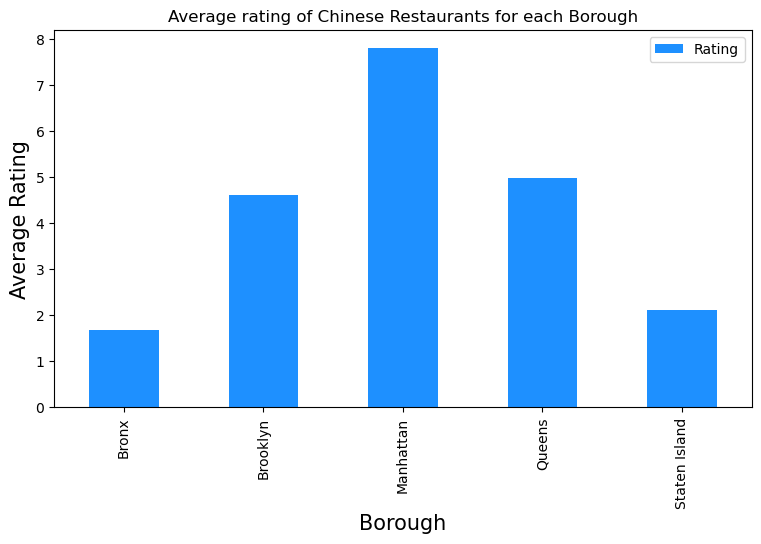

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Chinese Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
chinese_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color="dodgerblue")
plt.legend()
plt.show()

In [27]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
8,Boerum Hill,8.30
14,Chelsea,9.10
15,Chinatown,8.40
21,College Point,8.10
30,East Village,9.10
33,Elmhurst,8.30
45,Greenwich Village,8.40
57,Little Italy,8.55
59,Long Island City,8.50
60,Lower East Side,8.60


In [28]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Boerum Hill,40.685683,-73.983748,8.30
1,Manhattan,Chelsea,40.744035,-74.003116,9.10
2,Staten Island,Chelsea,40.594726,-74.189560,9.10
3,Manhattan,Chinatown,40.715618,-73.994279,8.40
4,Queens,College Point,40.784903,-73.843045,8.10
5,Manhattan,East Village,40.727847,-73.982226,9.10
6,Queens,Elmhurst,40.744049,-73.881656,8.30
7,Manhattan,Greenwich Village,40.726933,-73.999914,8.40
8,Manhattan,Little Italy,40.719324,-73.997305,8.55
9,Queens,Long Island City,40.750217,-73.939202,8.50


In [30]:
import folium

In [31]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
rating = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [32]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(rating)